In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Load and prepare the dataset
file_path = '/content/drive/MyDrive/GOOGL.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)


In [4]:
df[['Close']]

,Close
0,50.220219
1,54.209209
2,54.754753
3,52.487488
4,53.053055
...,...
4426,2722.510010
4427,2722.030029
4428,2797.360107
4429,2765.510010


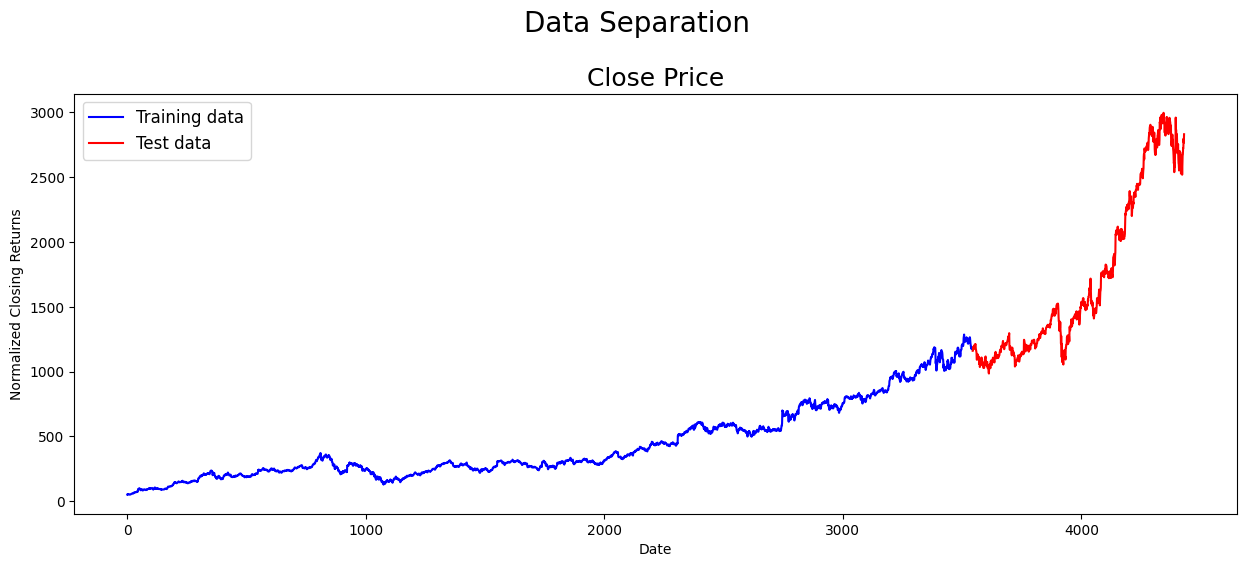

In [5]:
train_size = int(len(data_scaled) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Create the plot
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

# Plot the training data in one color (e.g., blue)
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), train_data, label='Training data', color='blue')

# Plot the test data in another color (e.g., red)
ax1.plot(np.arange(train_data.shape[0], train_data.shape[0] + test_data.shape[0]), test_data, label='Test data', color='red')

# Labeling the axes and setting title
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)

# Add legend
ax1.legend(loc="best", fontsize=12)

# Display the plot
plt.show()


In [6]:

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

time_step = 100
training_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)





In [7]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [21]:

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error",metrics=["mae"])

# Model Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 1)         │              2 │ input_layer_2[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 100, 1)         │          7,169 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 100, 1)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 1)         │              0 │ dropout_5[0][0],       │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 100, 1)         │              2 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 100, 4)         │              8 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 100, 4)         │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 100, 1)         │              5 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 100, 1)         │              0 │ dense_6[0][0],         │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 100)            │              0 │ add_3[0][0]            │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 100)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 20)             │          2,020 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │             21 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,227 (36.04 KB)

 Trainable params: 9,227 (36.04 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# Train the model
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 648ms/step - loss: 0.0202 - mae: 0.1026 - val_loss: 0.0092 - val_mae: 0.0784
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 643ms/step - loss: 0.0013 - mae: 0.0257 - val_loss: 0.0018 - val_mae: 0.0300
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 646ms/step - loss: 9.8566e-04 - mae: 0.0215 - val_loss: 0.0018 - val_mae: 0.0311
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 617ms/step - loss: 7.4277e-04 - mae: 0.0188 - val_loss: 0.0018 - val_mae: 0.0310
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 593ms/step - loss: 6.5925e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 622ms/step - loss: 5.8649e-04 - mae: 0.0162 - val_loss: 0.0011 - val_mae: 0.0241
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 642ms/step - loss: 5.8453e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0239
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 643ms/step - loss: 4.8369e-04 - mae: 0.0147 - val_loss: 9.4534e-04 - val_mae: 0.0228
Epoch 9/50
45/45 ━━━

In [23]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)



90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step


In [24]:
# Evaluate the model (Optional: Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train, scaler.inverse_transform(train_predict.reshape(-1, 1))))
test_rmse = math.sqrt(mean_squared_error(y_test, scaler.inverse_transform(test_predict.reshape(-1, 1))))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 1104774.395016774
Test RMSE: 4533494.337514176


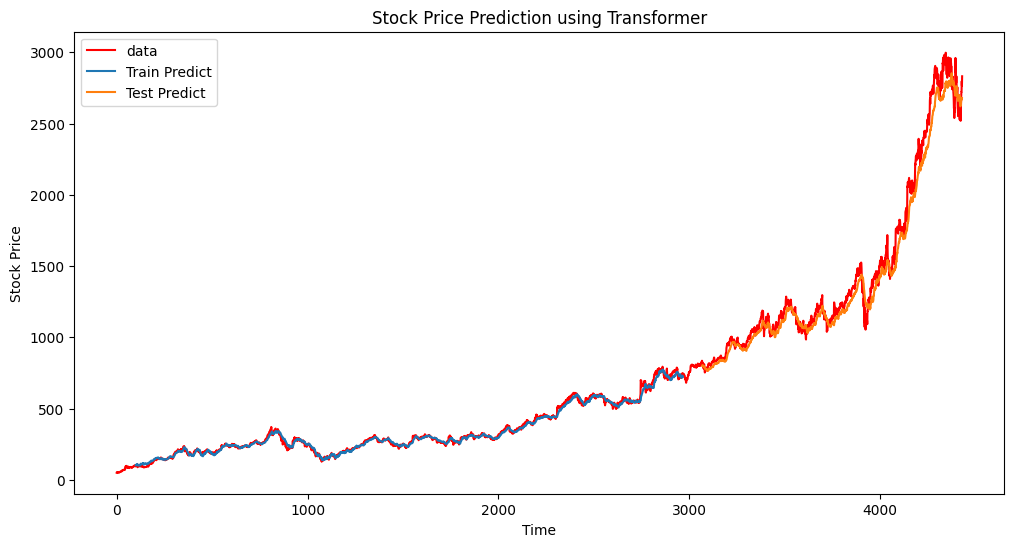

In [25]:

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='data',color='red')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

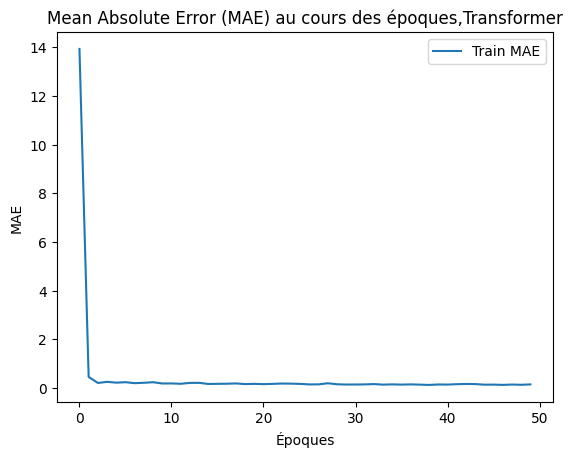

In [28]:
import matplotlib.pyplot as plt

# Afficher les courbes de MAE
plt.plot(history.history['mae'], label='Train MAE')
#plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) au cours des époques,Transformer')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [27]:
modelRNN = tf.keras.models.Sequential([
    tf.keras.Input(shape=(100,1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),  #RNN posséde 40 neurones
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
modelRNN.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
#history = model.fit(dataset,epochs=100)
history = modelRNN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 32.1534 - mae: 32.6370 - val_loss: 4.7269 - val_mae: 5.2269
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.3114 - mae: 0.6622 - val_loss: 1.8083 - val_mae: 2.2971
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0378 - mae: 0.2045 - val_loss: 1.6277 - val_mae: 2.1078
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0522 - mae: 0.2543 - val_loss: 1.9982 - val_mae: 2.4956
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0440 - mae: 0.2282 - val_loss: 1.9918 - val_mae: 2.4895
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0517 - mae: 0.2555 - val_loss: 1.6261 - val_mae: 2.1156
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0342 - mae: 0.1973 - val_loss: 1.4851 - val_mae: 1.9665
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0349 - mae: 0.2045 - val_loss: 1.1716 - val_mae: 1.6298
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0

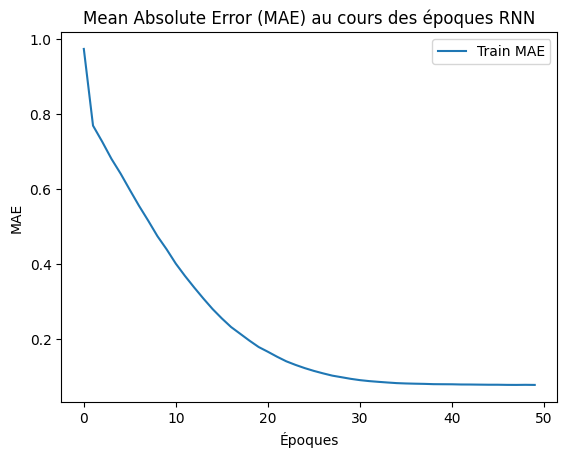

In [40]:
import matplotlib.pyplot as plt

# Afficher les courbes de MAE
plt.plot(history.history['mae'], label='Train MAE')
#plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) au cours des époques RNN')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [30]:

# Make predictions
train_predict = modelRNN.predict(X_train)
test_predict = modelRNN.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
train_predictp = train_predict.reshape(-1)
test_predictp = test_predict.reshape(-1)
datap=data.reshape(-1)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


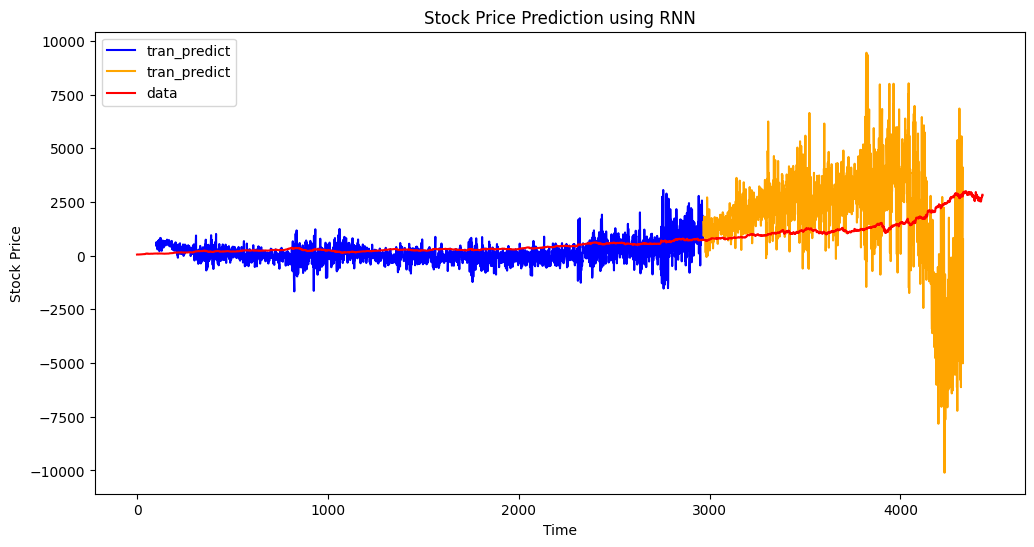

In [31]:
ypoints=np.arange(0,200+len(train_predictp)+len(test_predictp)+2,1)
plt.figure(figsize=(12, 6))
plt.plot(ypoints[100:100+len(train_predictp)],train_predictp,label='tran_predict',color='blue')
plt.plot(ypoints[100+len(train_predictp):100+len(train_predictp)+len(test_predictp)],test_predictp,label='tran_predict',color='orange')
plt.plot(ypoints,datap,label='data',color='red')
plt.title('Stock Price Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [33]:
modellstm = tf.keras.models.Sequential([
    tf.keras.Input(shape=(100, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
modellstm.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = modellstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - loss: 0.7710 - mae: 1.1827 - val_loss: 6.1287 - val_mae: 6.6287
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.4306 - mae: 0.7787 - val_loss: 5.9032 - val_mae: 6.4032
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.3855 - mae: 0.7292 - val_loss: 5.4159 - val_mae: 5.9159
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.3667 - mae: 0.7116 - val_loss: 5.1211 - val_mae: 5.6211
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - loss: 0.3193 - mae: 0.6551 - val_loss: 4.5816 - val_mae: 5.0816
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - loss: 0.2812 - mae: 0.6176 - val_loss: 4.2067 - val_mae: 4.7067
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - loss: 0.2396 - mae: 0.5621 - val_loss: 3.8026 - val_mae: 4.3026
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.2128 - mae: 0.5351 - val_loss: 3.5384 - val_mae: 4.0384
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/ste

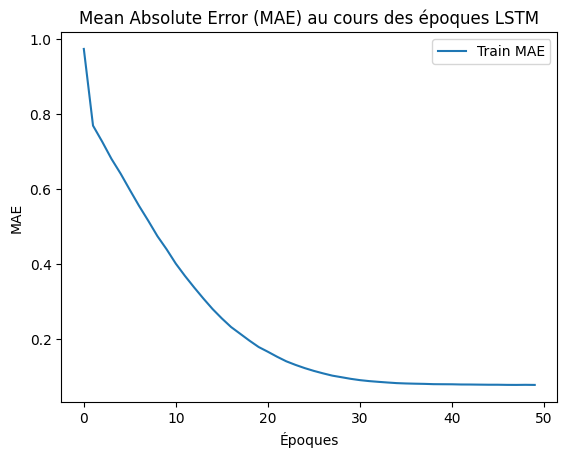

In [39]:
import matplotlib.pyplot as plt

# Afficher les courbes de MAE
plt.plot(history.history['mae'], label='Train MAE')
#plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) au cours des époques LSTM')
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [35]:

# Make predictions
train_predict_lstm = modellstm.predict(X_train)
test_predict_lstm = modellstm.predict(X_test)

# Inverse transform predictions
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
train_predict_lstm = train_predict_lstm.reshape(-1)
test_predict_lstm = test_predict_lstm.reshape(-1)
datap=data.reshape(-1)


90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


In [36]:
train_predict_lstm.shape

(2867,)

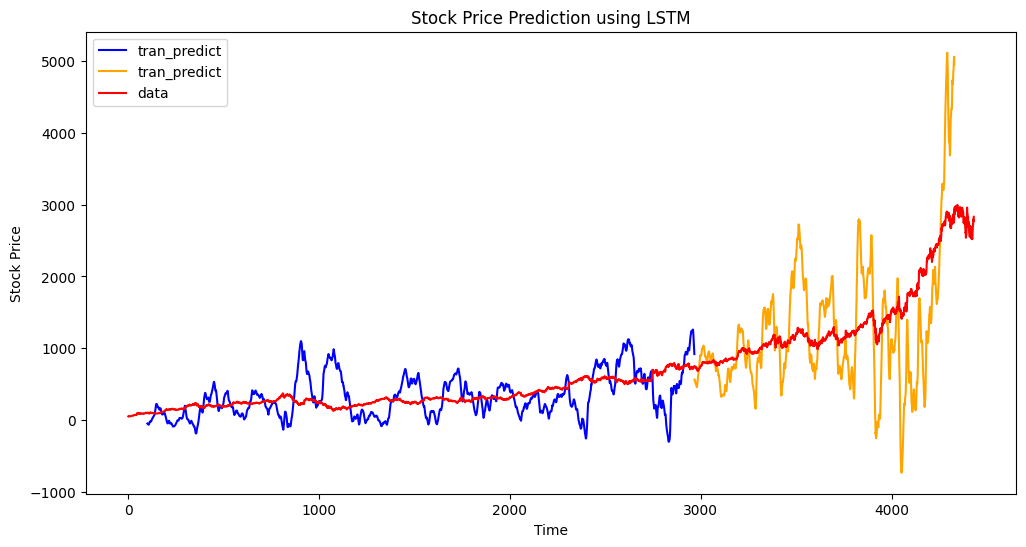

In [38]:
ypoints=np.arange(0,200+len(train_predict_lstm)+len(test_predict_lstm)+2,1)
plt.figure(figsize=(12, 6))
plt.plot(ypoints[100:100+len(train_predict_lstm)],train_predict_lstm,label='tran_predict',color='blue')
plt.plot(ypoints[100+len(train_predict_lstm):100+len(train_predict_lstm)+len(test_predict_lstm)],test_predict_lstm,label='tran_predict',color='orange')
plt.plot(ypoints,datap,label='data',color='red')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)